In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [80]:
ab_df = pd.read_csv('../../data/interim/absences_per_day.csv', sep=',')
#only keep columns index and count 
ab_df = ab_df[['index', 'count']]
#rename index to date
ab_df = ab_df.rename(columns={'index': 'date'})
ab_df['date'] = pd.to_datetime(ab_df['date'])
# drop data older than 2023-03-01
ab_df = ab_df[ab_df['date'] < '2023-03-01']

ab_df

,date,count
0,2020-01-02,2
1,2020-01-03,2
2,2020-01-04,2
3,2020-01-05,1
4,2020-01-06,1
...,...,...
1149,2023-02-24,194
1150,2023-02-25,216
1151,2023-02-26,68
1152,2023-02-27,114


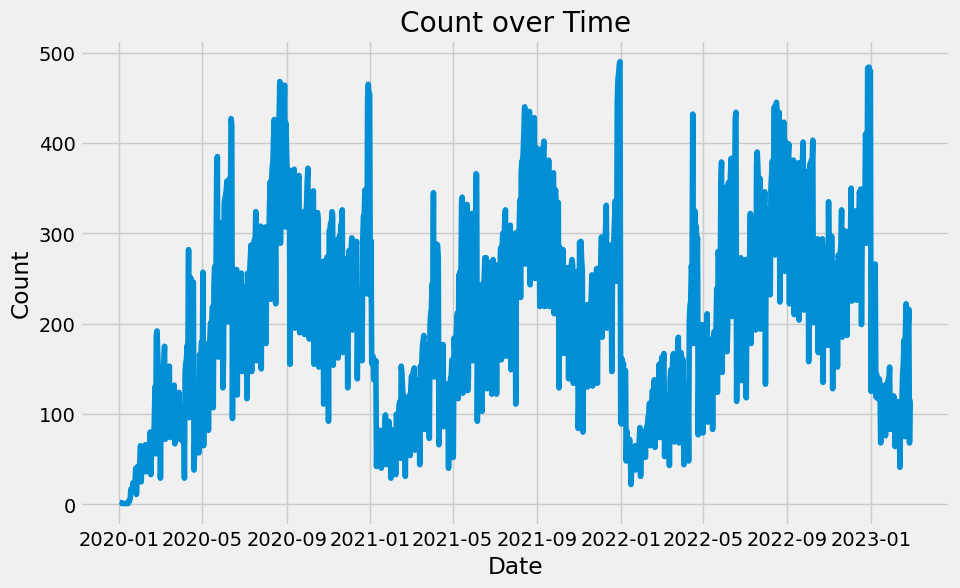

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(ab_df['date'], ab_df['count'], marker='o', linestyle='-', markersize=1)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Time')
plt.grid(True)
plt.show()

In [84]:
split_date = '01-Jul-2022'
ab_train = ab_df.loc[ab_df['date'] <= split_date].copy()
ab_test = ab_df.loc[ab_df['date'] > split_date].copy()

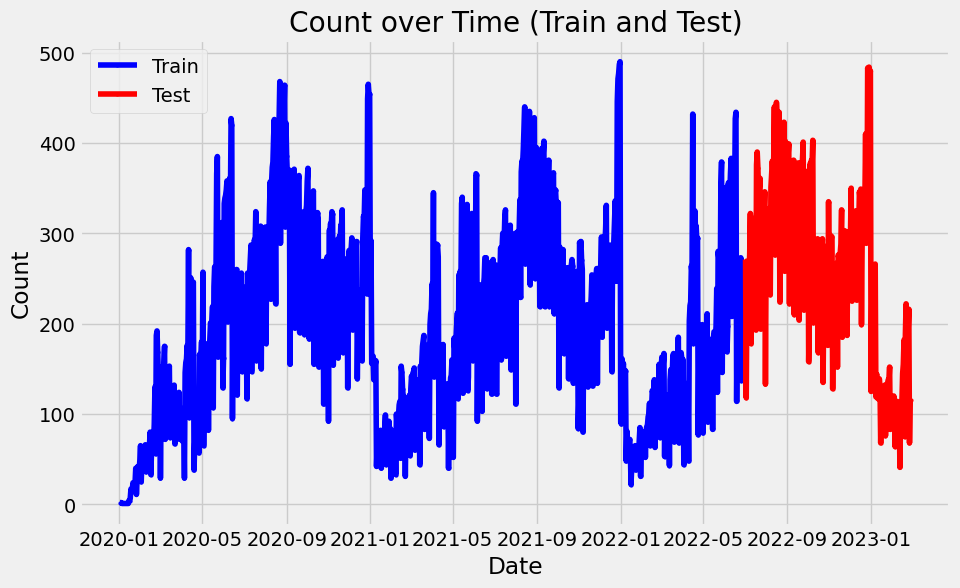

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(ab_train['date'], ab_train['count'], marker='o', linestyle='-', markersize=2, color='blue', label='Train')

# Plot the test set with another color (e.g., red)
plt.plot(ab_test['date'], ab_test['count'], marker='o', linestyle='-', markersize=2, color='red', label='Test')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Time (Train and Test)')
plt.legend()  # Add legend to distinguish between Train and Test
plt.grid(True)
plt.show()

In [86]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['date']
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [87]:
X_train, y_train = create_features(ab_train, label='count')
X_test, y_test = create_features(ab_test, label='count')

C:\Users\jakob\AppData\Local\Temp\ipykernel_4936\1007601217.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\jakob\AppData\Local\Temp\ipykernel_4936\1007601217.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [88]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train



c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

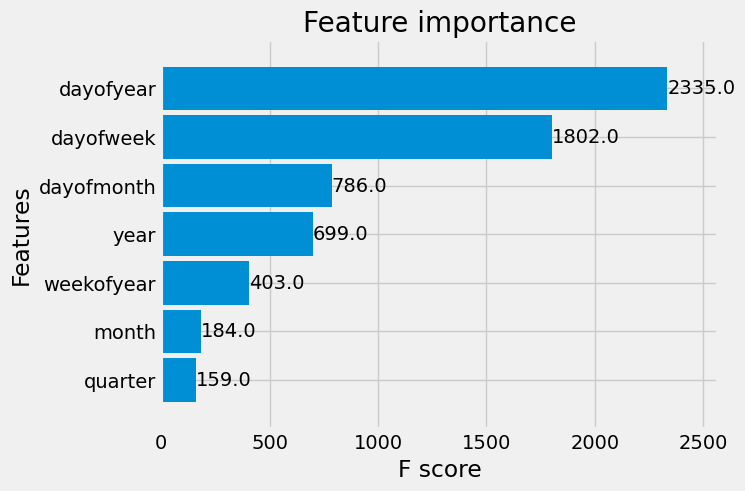

In [89]:
_ = plot_importance(reg, height=0.9)


In [90]:
ab_test['absence_Prediction'] = reg.predict(X_test)
count_all = pd.concat([ab_test, ab_train], sort=False)


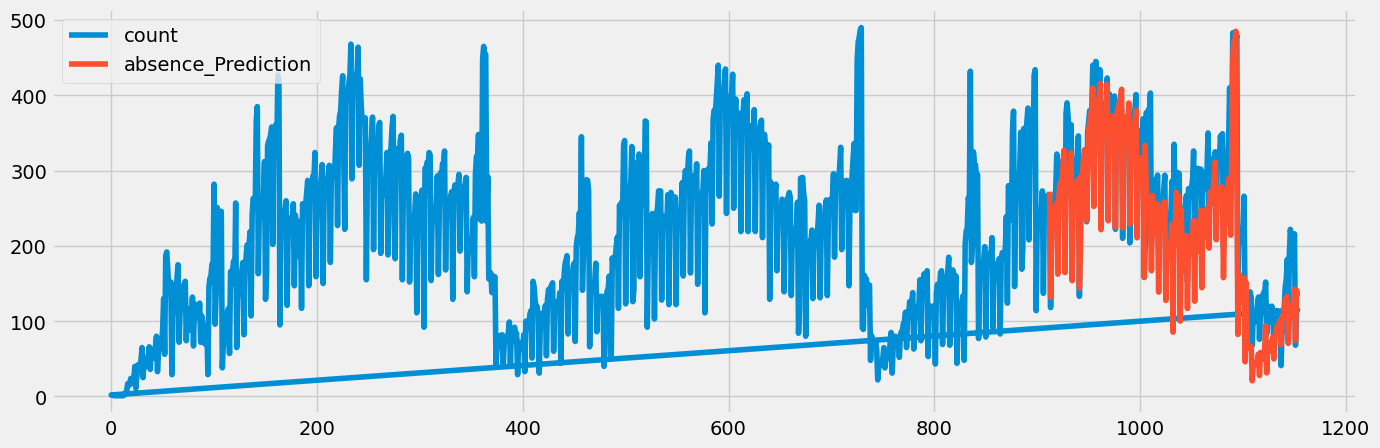

In [91]:
_ = count_all[['count','absence_Prediction']].plot(figsize=(15, 5))


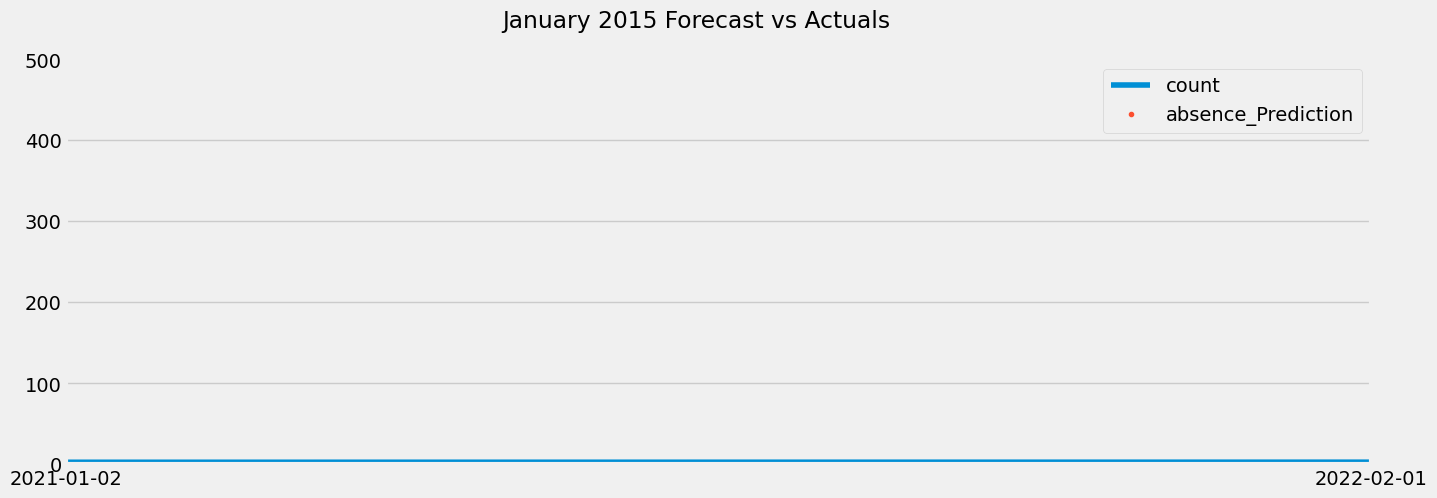

In [92]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = count_all[['count','absence_Prediction']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2021-01-02', upper='2022-02-01')
ax.set_ylim(0, 500)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [ ]:
y_train

In [ ]:
y_test

In [93]:
# Train the XGBoost model
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

# Make predictions on the test data
y_pred = reg.predict(X_test)




c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [69]:
y_pred

array([ 88.37235 , 130.0073  , 130.0073  , 130.0073  , 130.0073  ,
       130.0073  , 130.0073  ,  62.72077 ,  64.75947 ,  64.75947 ,
        64.75947 ,  64.75947 ,  68.24185 ,  68.24185 ,  37.63957 ,
        68.24185 ,  68.24185 ,  68.24185 ,  70.17248 ,  70.17248 ,
        70.17248 ,  39.570198,  70.17248 ,  70.17248 ,  70.17248 ,
        70.17248 ,  70.17248 ,  70.17248 ,  34.993946,  65.076324,
        62.232765,  62.232765,  62.232765,  62.232765,  62.232765,
        34.325478,  77.999115,  83.15531 ,  83.15531 ,  83.15531 ,
        88.78078 ,  96.43337 ,  42.79577 ,  96.43337 , 102.043106,
       102.043106, 102.043106, 102.043106, 106.12037 ,  32.688362,
        97.41829 ,  97.41829 ,  97.41829 ,  97.41829 ,  97.41829 ,
       101.49555 ,  39.586628,  95.71051 ,  95.71051 ,  95.71051 ,
        95.71051 , 108.52738 , 118.8678  ,  53.551414,  95.71051 ,
        95.71051 ,  95.71051 ,  95.71051 , 108.52738 , 118.8678  ,
        47.73641 , 103.959465, 103.959465, 103.959465, 103.959

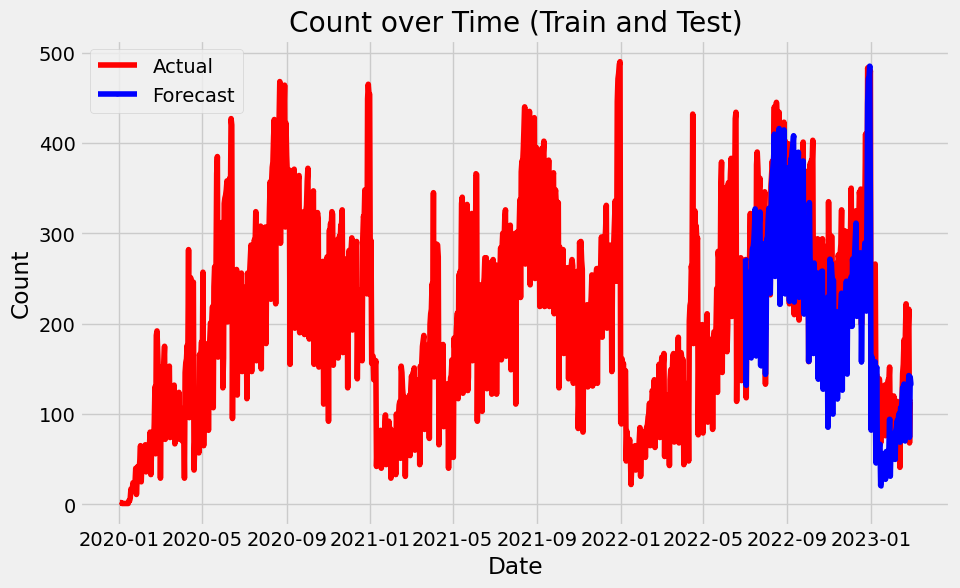

In [94]:
plt.figure(figsize=(10, 6))

# Plot the test set with another color (e.g., red)
plt.plot(ab_df['date'], ab_df['count'], marker='o', linestyle='-', markersize=1, color='red', label='Actual')
plt.plot(ab_test['date'], y_pred, marker='o', linestyle='-', markersize=2, color='blue', label='Forecast')

#plt.plot(ab_train['date'], ab_train['count'], marker='o', linestyle='-', markersize=2, color='red', label='Test')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Time (Train and Test)')
plt.legend()  # Add legend to distinguish between Train and Test
plt.grid(True)
plt.show()